### Project Computer Vision 2 ###

DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. 
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the 

• DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.

• PROJECT OBJECTIVE: To build a face detection system

1. Import and Understand the data 

In [1]:
# Import the required modules

import numpy as np
import pandas as pd
from zipfile import ZipFile
import os

*** Q 1A. Import and read ‘images.npy’ ***

*** Ans 1A ***


In [2]:
# Read the images.npy
data_arr = np.load('Project_CV2\images.npy', allow_pickle=True)


In [3]:
data_arr.size


818

*** Q 1B. Split the data into Features(X) & labels(Y). Unify shape of all the images. ***

*** Ans 1B ***

In [4]:
X_Ftr, Y_Lbl = np.split(data_arr,[-1],1)

In [5]:
X_Ftr.size

409

In [6]:
Y_Lbl.size

409

In [147]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

#Declare empty arrays
X_train_arr = [0]*409
y_train_arr = np.zeros((409, IMAGE_HEIGHT, IMAGE_WIDTH))

i = 0
#Iterate through the features and labels to store image and mask co-ordinates
for idx, t_img in enumerate(X_Ftr):
    if(len(X_Ftr[idx][0].shape) > 2):
        resz_img = cv2.resize(X_Ftr[idx][0], (IMAGE_HEIGHT, IMAGE_WIDTH))
        #resz_img = cv2.cvtColor(resz_img, cv2.COLOR_BGR2RGB)
        t_arr = preprocess_input(np.array(resz_img, dtype=np.float32))
        # save image data 
        X_train_arr[i] = t_arr[:,:,:3]
        # Retrieve mask co-ordinates 
        x0 = int(Y_Lbl[idx][0][0]['points'][0]['x']*IMAGE_WIDTH)
        y0 = int(Y_Lbl[idx][0][0]['points'][0]['y']*IMAGE_HEIGHT)
        x1 = int(Y_Lbl[idx][0][0]['points'][1]['x']*IMAGE_WIDTH)
        y1 = int(Y_Lbl[idx][0][0]['points'][1]['y']*IMAGE_HEIGHT)
        img_wd = Y_Lbl[idx][0][0]['imageWidth']
        img_ht = Y_Lbl[idx][0][0]['imageHeight']
        y_train_arr[i][y0:y1, x0:x1] = 1
        i = i + 1

X_train_arr = X_train_arr[:i]
y_train_arr = y_train_arr[:i]
X_train_arr = np.asarray(X_train_arr).astype(np.float32)
print(X_train_arr.shape)
print(y_train_arr.shape)



(408, 224, 224, 3)
(408, 224, 224)


*** Q 1C. Split the data into train and test[400:9]***

*** Ans 1C.***

In [148]:
X_train = X_train_arr[0:400]
X_test  = X_train_arr[400:]
y_train = y_train_arr[0:400]
y_test  = y_train_arr[400:]

In [149]:
print( 'X_train : ' , X_train.shape, 'X_test : ' , X_test.shape, 'y_train : ' , y_train.shape, 'y_test : ' , y_test.shape)

X_train :  (400, 224, 224, 3) X_test :  (8, 224, 224, 3) y_train :  (400, 224, 224) y_test :  (8, 224, 224)


*** Q 1D. Select random image from the train data and display original image and masked image. ***

*** Ans 1D. ***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


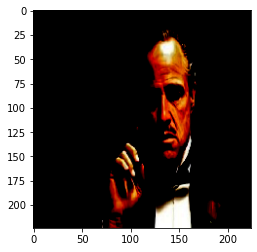

In [150]:
#Display the image
rnd_num = 10
plt.imshow(X_train[rnd_num])
plt.show()





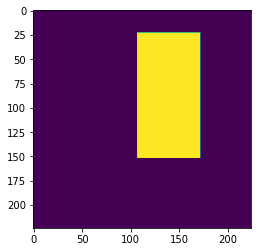

In [151]:
# display the mask
plt.imshow((y_train[rnd_num]))
plt.show()


*** 2. Model building *** 

*** Q 2A. Design a face mask detection model. ***

*** Ans 2A ***


Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers.

Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture

In [272]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D, Activation, Input
from tensorflow.keras.models import Model

ALPHA = 1.0

# a method to return the customized Mobilenet model
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable
                      
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output
    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x)])
    x = Concatenate()([UpSampling2D()(x)])
    x = Concatenate()([UpSampling2D()(x)])
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x2 = Reshape((224,224, ))(x)
    return Model(inputs=model.input, outputs=x2)


*** Q 2B. Design your own Dice Coefficient and Loss function.***

***Ans 2B. ***

In [235]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [236]:
#Define loss function
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())


*** Q 2C. Train and tune the model as required. ***

***Ans 2C***

In [273]:
# Create the model
model = create_model(False)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_65[0][0]']               
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                          

 on)                                                                                              
                                                                                                  
 conv_dw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_dw_5_bn[0][0]']           
                                                                                                  
 conv_pw_5 (Conv2D)             (None, 28, 28, 256)  65536       ['conv_dw_5_relu[0][0]']         
                                                                                                  
 conv_pw_5_bn (BatchNormalizati  (None, 28, 28, 256)  1024       ['conv_pw_5[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_pw_5_bn[0][0]']           
          

 conv_dw_11 (DepthwiseConv2D)   (None, 14, 14, 512)  4608        ['conv_pw_10_relu[0][0]']        
                                                                                                  
 conv_dw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_dw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_dw_11_relu (ReLU)         (None, 14, 14, 512)  0           ['conv_dw_11_bn[0][0]']          
                                                                                                  
 conv_pw_11 (Conv2D)            (None, 14, 14, 512)  262144      ['conv_dw_11_relu[0][0]']        
                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_pw_11[0][0]']             
 ion)     

In [275]:
# Compile the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[dice_coefficient])

In [276]:
# Create check point callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Project_CV2/vgg_face_weights.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [277]:
import tensorflow as tf

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=5, batch_size=32, verbose=1)
#model.fit(X_train_arr, y_train_arr, validation_split = 0.2, epochs=10, batch_size=32, verbose=1)

Epoch 1/5
13/13 [==============================] - 151s 10s/step - loss: 88.0846 - dice_coefficient: 0.1158 - val_loss: 104.8470 - val_dice_coefficient: 0.1610
Epoch 2/5
13/13 [==============================] - 109s 8s/step - loss: 85.0447 - dice_coefficient: 0.1282 - val_loss: 104.1091 - val_dice_coefficient: 0.1674
Epoch 3/5
13/13 [==============================] - 101s 8s/step - loss: 83.9685 - dice_coefficient: 0.1327 - val_loss: 104.0180 - val_dice_coefficient: 0.1683
Epoch 4/5
13/13 [==============================] - 108s 8s/step - loss: 83.5812 - dice_coefficient: 0.1339 - val_loss: 104.0069 - val_dice_coefficient: 0.1683
Epoch 5/5
13/13 [==============================] - 103s 8s/step - loss: 83.4153 - dice_coefficient: 0.1315 - val_loss: 103.9472 - val_dice_coefficient: 0.1688



*** Q 2D. Evaluate and share insights on performance of the model. ***

*** Ans 2D. ***

In [278]:
#Evaluate the model
model.evaluate( X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 103.9472 - dice_coefficient: 0.1688


[103.94719696044922, 0.16880500316619873]


***Q 3. 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.***
    
***Ans 3.***
    

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


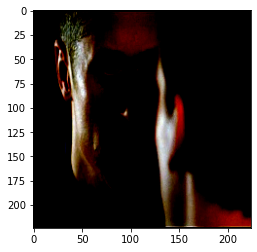

In [285]:
img_temp = X_test[3]

# Retrieve the mask data
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([img_temp]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

plt.imshow(img_temp)
plt.show()

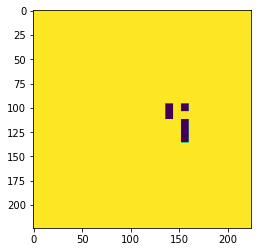

In [286]:
plt.imshow(pred_mask)
plt.show()

### Part B ###

• DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the 

• DATA DESCRIPTION: The dataset comprises of face images.

• PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

*** Q 1. Read/import images from folder ‘training_images’. ***

*** Ans 1 ***

In [51]:
from PIL import Image
import cv2
from glob import glob
from numpy import asarray

In [52]:
X_data = []
y_data = []

#Read the images and store the info in arrays 
img_path = 'Project_CV2/training_images/'
files =  os.listdir(img_path)
i = 0
for filNm in files:
    filPathNm = img_path + filNm
    # Read the image data
    img_bin = cv2.imread(filPathNm)
    img_arr = asarray(img_bin)
    i = i + 1
    print(i , " : " , img_arr.size)    
    X_data.append(img_arr)
    y_data.append(filNm)

    

1  :  1080000
2  :  1080000
3  :  1080000
4  :  1080000
5  :  1080000
6  :  1080000
7  :  1080000
8  :  1080000
9  :  1080000
10  :  1080000
11  :  1080000
12  :  1080000
13  :  1080000
14  :  1080000
15  :  1080000
16  :  1080000
17  :  1080000
18  :  1080000
19  :  1080000
20  :  1080000
21  :  1080000
22  :  1080000
23  :  1080000
24  :  1080000
25  :  1080000
26  :  1080000
27  :  1080000
28  :  1080000
29  :  1080000
30  :  1080000
31  :  1080000
32  :  1080000
33  :  1080000
34  :  1080000
35  :  1080000
36  :  1080000
37  :  1080000
38  :  1080000
39  :  1080000
40  :  1080000
41  :  1080000
42  :  1080000
43  :  1080000
44  :  1080000
45  :  1080000
46  :  1080000
47  :  1080000
48  :  1080000
49  :  1080000
50  :  1080000
51  :  1080000
52  :  1080000
53  :  1080000
54  :  1080000
55  :  1080000
56  :  1080000
57  :  1080000
58  :  1080000
59  :  1080000
60  :  1080000
61  :  1080000
62  :  1080000
63  :  1080000
64  :  1080000
65  :  1080000
66  :  1080000
67  :  1080000
68  

528  :  1080000
529  :  1080000
530  :  1080000
531  :  1080000
532  :  1080000
533  :  1080000
534  :  1080000
535  :  1080000
536  :  1080000
537  :  1080000
538  :  1080000
539  :  1080000
540  :  1080000
541  :  1080000
542  :  1080000
543  :  1080000
544  :  1080000
545  :  1080000
546  :  1080000
547  :  1080000
548  :  1080000
549  :  1080000
550  :  1080000
551  :  1080000
552  :  1080000
553  :  1080000
554  :  1080000
555  :  1080000
556  :  1080000
557  :  1080000
558  :  1080000
559  :  1080000
560  :  1080000
561  :  1080000
562  :  1080000
563  :  1080000
564  :  1080000
565  :  1080000
566  :  1080000
567  :  1080000
568  :  1080000
569  :  1080000
570  :  1080000
571  :  1080000
572  :  1080000
573  :  1080000
574  :  1080000
575  :  1080000
576  :  1080000
577  :  1080000
578  :  1080000
579  :  1080000
580  :  1080000
581  :  1080000
582  :  1080000
583  :  1080000
584  :  1080000
585  :  1080000
586  :  1080000
587  :  1080000
588  :  1080000
589  :  1080000
590  :  

1043  :  1080000
1044  :  1080000
1045  :  1080000
1046  :  1080000
1047  :  1080000
1048  :  1080000
1049  :  1080000
1050  :  1080000
1051  :  1080000
1052  :  1080000
1053  :  1080000
1054  :  1080000
1055  :  1080000
1056  :  1080000
1057  :  1080000
1058  :  1080000
1059  :  1080000
1060  :  1080000
1061  :  1080000
1062  :  1080000
1063  :  1080000
1064  :  1080000
1065  :  1080000
1066  :  1080000
1067  :  1080000
1068  :  1080000
1069  :  1080000
1070  :  1080000
1071  :  1080000
1072  :  1080000
1073  :  1080000
1074  :  1080000
1075  :  1080000
1076  :  1080000
1077  :  1080000
1078  :  1080000
1079  :  1080000
1080  :  1080000
1081  :  1080000
1082  :  1080000
1083  :  1080000
1084  :  1080000
1085  :  1080000
1086  :  1080000
1087  :  1080000
1088  :  1080000
1089  :  1080000
1090  :  1080000
1091  :  1080000



*** Q 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. ***

Hint: You can use ’haarcascade_frontalface_default.xml’ from internet to detect faces which is available open source.

In [53]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Create a emoty dataframe and use column names to store image name or file name,  folder or specirs name and actual image data
img_df = pd.DataFrame( columns=['x', 'y', 'h', 'Total_Faces', 'Image_Name'])

for ilen in range(0, len(X_data)):
    #print(ilen, ' : ', y_data[ilen])
    # Reading the image
    img = X_data[ilen]
  
    # Converting image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray_img = img
  
    # Loading the required haar-cascade xml classifier file
    haar_cascade = cv2.CascadeClassifier('Project_CV2/haarcascade_frontalface_default.xml')

    # Applying the face detection method on the grayscale image
    faces_rect = haar_cascade.detectMultiScale(gray_img, 1.1, 4)
  
    # Iterating through rectangles of detected faces
    num_of_faces = 0
    x1 = y1 = w1 = h1 = 0
    for (x, y, w, h) in faces_rect:
        x1 = y1 = w1 = h1 = 0
        if w > 0:
            num_of_faces = num_of_faces + 1
        x1 = x
        y1 = y
        w1 = w
        h1 = h    
        cv2.rectangle(gray_img, (x, y), (x+w, y+h), (0, 0, 255), 2)

    img_df = img_df.append({'x':x1, 'y':y1, 'w':w1, 'h':h1, 'Total_Faces': num_of_faces, 'Image_Name': y_data[ilen]}, ignore_index = True )


img_df.head()  


,x,y,h,Total_Faces,Image_Name,w
0,146,140,428,1,real_00001.jpg,428.0
1,80,140,436,1,real_00002.jpg,436.0
2,33,121,362,1,real_00003.jpg,362.0
3,13,12,162,3,real_00004.jpg,162.0
4,0,0,0,0,real_00005.jpg,0.0



*** Q 3. From the same loop above, extract metadata of the faces and write into a DataFrame. ***

*** Ans 3.***
Added the Dataframe code snippet in the loop in Ans 2 


*** Q 4. Save the output Dataframe in .csv format ***

*** Ans 4. ***

In [54]:
# Use the DataFrame's to_csv function to write to CSV file
img_df.to_csv("Project_CV2/training_images_properties.csv")

---

### Part C ###

• DOMAIN: Face Recognition
    
• CONTEXT: Company X intends to build a face identification model to recognise human faces.
    
• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face
    
• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken 
from 'Pinterest' and aligned using dlib library. Some data samples


*** Q 1. Unzip, read and Load data(‘PINS.zip’) into session. ***

*** Ans 1 ***

In [287]:
from zipfile import ZipFile

In [288]:


#read the zip file
try:
    with ZipFile('Project_CV2\PINS.zip', 'r')  as zipfl:
        # Construct the path 
        current_dir = os.getcwd()

        path = os.path.join(current_dir, 'Project_CV2')
        #Extract the files
        zipfl.extractall(path=path)
except:
    print("File Error")

File Error



*** Q 2. Write function to create metadata of the image. ***

*** Ans 2. ***

Hint: Metadata means derived information from the available data which can be useful for particular problem statement

In [180]:
#Define a class to capture each image details
class ImageMetadata():
    def __init__(self, imgpath, fldr, file):
        # image path
        self.imgpath = imgpath
        # Fldr
        self.Fldrnm = fldr
        # image file name
        self.filenm = file


* Q 3. Write a loop to iterate through each and every image and create metadata for all the images *

* Ans 3.*

In [181]:
# a function to iterate through the folder structure and load image details
def load_metadata(path):
    metadata = []
    # Get a list of subfolder path under the path
    subFldr = [fldr.path for fldr in os.scandir(path) if fldr.is_dir()]
    
    #Iterate the subfolder or species folder
    for Idx, fldrpth in enumerate(subFldr):
        #print( 'folder : ', fldrpth )
        img_path = fldrpth + '/'
        # Obtain a list of image files under each species folder
        files =  os.listdir(img_path)
        for filNm in files:
            filPathNm = img_path + filNm
            metadata.append(ImageMetadata(filPathNm, subFldr[Idx], filNm))
    return np.array(metadata)

In [182]:
# Load the filename list
meta_lst = load_metadata('Project_CV2/PINS/')
print(meta_lst[0].filenm)

Aaron Paul0_262.jpg


*** Q 4. Generate Embeddings vectors on the each face in the dataset.  ***

*** Ans 4.***

In [183]:
from numpy import asarray

# A Function to retireve a image vector or pixel details from the gicen path
def getImgVector(path):
    img_bin = cv2.imread(path)
    # converting BGR to RGB
    image_rgb = cv2.cvtColor(img_bin, cv2.COLOR_BGR2RGB)
    #img_arr = asarray(image_rgb)   
    return image_rgb




In [184]:
# A model to use for embeddings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [187]:
# create the model and load the existing weights
model = vgg_face()
model.load_weights('Project_CV2/vgg_face_weights.h5')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_26 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_33 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_27 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_34 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                      

In [186]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [188]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [189]:
img_data = getImgVector(meta_lst[0].imgpath)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img_data / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

print(embedding_vector.shape)


(224, 224, 3)
1/1 [==============================] - 0s 203ms/step
(2622,)


In [190]:
embedding_vector

array([ 0.03170304, -0.01505131, -0.01243401, ...,  0.0004314 ,
        0.00219081, -0.00908097], dtype=float32)

In [191]:
embeddings = np.zeros((meta_lst.shape[0], 2622))

#Genearte embeddings for all the images
for i, m in enumerate(meta_lst):
    img_data = getImgVector(m.imgpath)
    img = (img_data / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0] 
    


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 115ms/step


In [192]:
embeddings_arr[0].shape

(2622,)


*** Q 5. Build distance metrics for identifying the distance between two similar and dissimilar images. ***

*** Ans 5. ***


In [193]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

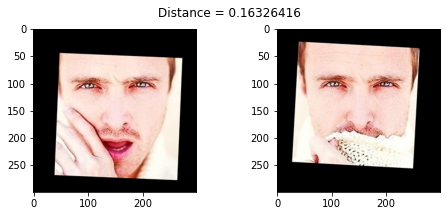

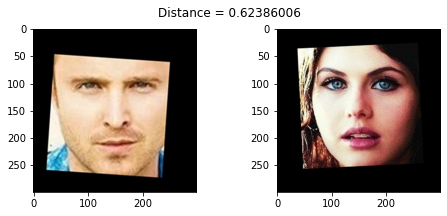

In [194]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.8f}')
    plt.subplot(121)
    plt.imshow(getImgVector(meta_lst[idx1].imgpath))
    plt.subplot(122)
    plt.imshow(getImgVector(meta_lst[idx2].imgpath));

show_pair(2, 3)
show_pair(29,100)


*** Q 6. Use PCA for dimensionality reduction. ***

*** Ans 6 ***

In [196]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


In [235]:
train_idx = np.arange(meta_lst.shape[0]) % 9 != 0
test_idx = np.arange(meta_lst.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.Fldrnm for m in meta_lst])
y_train = targets[train_idx]
y_test = targets[test_idx]

#Trim the label to obtain class name (celebrity names) from the folder path
for inx , filpth in enumerate(y_train):
    y_train[inx] = filpth.split('_')[-1]
    
for inx , filpth in enumerate(y_test):
    y_test[inx] = filpth.split('_')[-1]

In [236]:
display(y_train, y_test)

array(['Aaron Paul', 'Aaron Paul', 'Aaron Paul', ..., 'William Fichtner',
       'William Fichtner', 'William Fichtner'], dtype='<U43')

array(['Aaron Paul', 'Aaron Paul', 'Aaron Paul', 'Aaron Paul',
       'Aaron Paul', 'Aaron Paul', 'Aaron Paul', 'Aaron Paul',
       'Aaron Paul', 'Aaron Paul', 'alexandra daddario',
       'alexandra daddario', 'alexandra daddario', 'alexandra daddario',
       'alexandra daddario', 'alexandra daddario', 'alexandra daddario',
       'alexandra daddario', 'alexandra daddario', 'alexandra daddario',
       'alexandra daddario', 'alexandra daddario', 'alexandra daddario',
       'alexandra daddario', 'alexandra daddario', 'alexandra daddario',
       'alexandra daddario', 'alexandra daddario', 'Alvaro Morte',
       'Alvaro Morte', 'Alvaro Morte', 'Alvaro Morte', 'Alvaro Morte',
       'Alvaro Morte', 'Alvaro Morte', 'Alvaro Morte', 'Alvaro Morte',
       'Alvaro Morte', 'Amaury Nolasco', 'Amaury Nolasco',
       'Amaury Nolasco', 'Amaury Nolasco', 'Amaury Nolasco',
       'Amaury Nolasco', 'Amaury Nolasco', 'Amaury Nolasco',
       'Amaury Nolasco', 'Amaury Nolasco', 'Amaury Nolasco',
 

In [237]:
# Encode the labels for classification 
encdr = LabelEncoder()
y_train_en = encdr.fit_transform(y_train)
y_test_en = encdr.fit_transform(y_test)
display(y_train_en.shape, y_test_en.shape)

(7322,)

(916,)

In [238]:
#Scale the features using StandardScaler
std_sc = StandardScaler()
X_train_ss = std_sc.fit_transform(X_train)
X_test_ss = std_sc.transform(X_test)

In [239]:
X_train_cp = X_train.copy()
X_test_cp = X_test.copy()

# Reducing the dimensions using PCA to 128 parameters 
pca = PCA(n_components = 128, random_state = 5)
pca.fit(X_train_ss)
X_train_trns = pca.transform(X_train_ss)
X_test_trns = pca.transform(X_test_ss)
display(X_train_trns.shape, X_test_trns.shape)

(7322, 128)

(916, 128)


***Q 7. Build an SVM classifier in order to map each image to its right person.***

***Ans 7.***

In [240]:
from sklearn.svm import SVC

In [241]:
svc_clfr = SVC(C = 1, gamma = 0.01, kernel = 'rbf', class_weight = 'balanced', random_state = 5)
svc_clfr.fit(X_train_trns, y_train_en)
svc_clfr.score(X_train_trns, y_train_en)


0.9997268505872713


***Q 8. Import and display the the test images***

***Ans 8.***

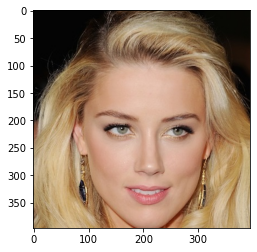

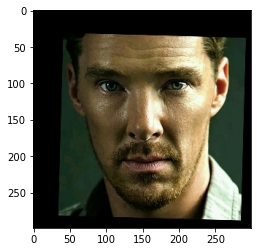

In [275]:
test_img1 = getImgVector('Project_CV2/AmberHeard.jpeg')
plt.imshow(test_img1)
plt.show()

test_img2 = getImgVector('Project_CV2/BenedictCumberbatch9.jpg')
plt.imshow(test_img2)
plt.show()
  

*** Q 9. Use the trained SVM model to predict the face on both test images***

*** Ans 9.***

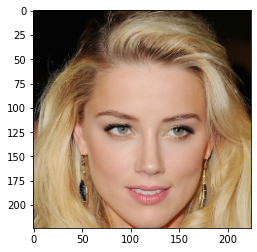

1/1 [==============================] - 0s 127ms/step
barbara palvin face


In [276]:
# Normalizing pixel values
test_img1 = (test_img1/255.).astype(np.float32)
# Resize
test_img1 = cv2.resize(test_img1, (224, 224))
plt.imshow(test_img1)
plt.show()
  
# Obtain embedding vector for sample image
embedding_tst1 = vgg_face_descriptor.predict(np.expand_dims(test_img1, axis = 0))[0]
    
# Scaled the vector and reshape
embedding_scaled1 = std_sc.transform(embedding_tst1.reshape(1, -1))
# Predict
test1_pred = svc_clfr.predict(pca.transform(embedding_scaled1))

pred_name1 = encdr.inverse_transform(test1_pred)[0]

print(pred_name1)

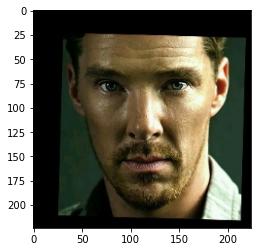

1/1 [==============================] - 0s 120ms/step
Benedict Cumberbatch


In [277]:
# Normalizing pixel values
test_img2 = (test_img2/255.).astype(np.float32)
# Resize
test_img2 = cv2.resize(test_img2, (224, 224))
plt.imshow(test_img2)
plt.show()

# Obtain embedding vector for sample image
embedding_tst2 = vgg_face_descriptor.predict(np.expand_dims(test_img2, axis = 0))[0]
    
# Scaled the vector and reshape
embedding_scaled2 = std_sc.transform(embedding_tst2.reshape(1, -1))
# Predict
test1_pred2 = svc_clfr.predict(pca.transform(embedding_scaled2))
    
pred_name2 = encdr.inverse_transform(test1_pred2)[0] 
print(pred_name2)